# Spooky Author Identification - Identify authors from their writings

This project was started as a [Spooky Author Identifaction Competition](https://www.kaggle.com/c/spooky-author-identification) from Kaggle. First, I'll do basic EDA on the dataset and try out couple of different models in order to predict authors from their writing with simple feature engineering(using word2vec). Next, I'll extract some named entities from writings and explain how to 

[1. Basic EDA](#1)  
[2. Generate a Model](#2)  
[3. Extract Named Entities](#3)  
[4. Model Comparison](#4)

## 0. Loading Libraries & Data Sets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import defaultdict

In [2]:
# train-test ratio 
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
print("training set size: {}".format(train.shape[0]))
print("test set size: {}".format(test.shape[0]))
print("train:test={}:{}".format(1,round(test.shape[0]/train.shape[0],2)) )

training set size: 19579
test set size: 8392
train:test=1:0.43


In [3]:
traintest = pd.concat([train, test])
print("No redundant ids: ", traintest.shape[0] == traintest.drop_duplicates('id').shape[0])

No redundant ids:  True


In [4]:
traintest['count'] = traintest.apply(lambda x: len(x.text), axis=1)
print("No null texts:", all(i > 0  for i in traintest['count'].tolist()))

No null texts: True


In [5]:
# First 5 rows of train data set 
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


* No redundancy in data - checked ! 
* No null texts in data - checked ! 

<a name='1'></a>
## 1. Basic EDA 
### Writing style of each author

In [6]:
# Check out each of author's writing style 
for author, df in train.groupby('author'):
    print(author,'-----')
    cnt = 0
    for idx, row in df.iterrows():
        print(row['text'])
        cnt += 1 
        if cnt ==2:
            break
    print('\n')

EAP -----
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.


HPL -----
It never once occurred to me that the fumbling might be a mere mistake.
Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.


MWS -----
How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.
A youth passed in solitude, my best years spent under your gentle and feminine 

### Summary Statistics

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


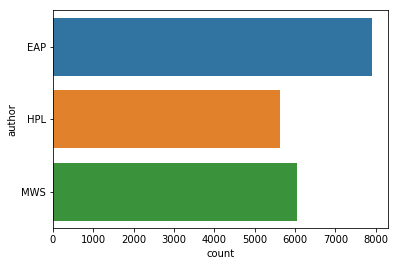

In [7]:
print(train['author'].value_counts())
sns.countplot(y='author', data=train)
plt.show()

* No class imbalance - checked!

<a name='2'></a>
## 2. Generate a Model

### Cleaning 
Building a simple tokenizer function in order to remove stop words and punctuation characters. The Gensim algorithms work on sentences instead of arbitrary documents.

In [8]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def tokenize(docs):
    pattern = stopwords.words("english") + list(punctuation)
    sentences = []
    for d in docs:
        sentence = word_tokenize(d)
        sentences.append([w for w in sentence if w not in pattern])
    return sentences 

In [9]:
sentences = tokenize(train.text)

### Generate features and  Build models

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

I'll try out `MultinomialNB`, `RandomForestClassifier`, and `SVC` with and without word embeddings. Therefore, there will be 6 different results. 
#### Models without word embeddings 

In [12]:
# mutlinomial NB
multi_nb = Pipeline([("tfidf_vectorizer", 
                      TfidfVectorizer(min_df=5, ngram_range=(1,3))),
                    ("mutlinomial nb", 
                     MultinomialNB())])
# Random Forest 
rf = Pipeline([("tfidf_vectorizer",
                           TfidfVectorizer(min_df=5, ngram_range=(1,3))),
                        ("random forest",
                         RandomForestClassifier(n_estimators=100))   
])

# SVM
svc = Pipeline([("tfidf_vectorizer", 
                 TfidfVectorizer(min_df=5, ngram_range=(1,3))),
               ("linear svc", 
                SVC(kernel="linear", probability=True))])

#### Benchmark on cross-validation scores

In [13]:
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

models = [
    ("multi nominal nb", multi_nb),
    ("random forest", rf),
    ("SVC", svc)
]

scores =  [(name, cross_val_score(model, train.text, train.author, cv=5).mean())
                for name, model in models]

print(tabulate(scores, floatfmt=".4f", headers=("model", "score")))

model               score
----------------  -------
multi nominal nb   0.8237
random forest      0.7039
SVC                0.8168


Cross validation results showed that simple models can predict authors pretty good. Next, I'll try out the same model but with word embeddings.

#### Models with word embeddings 

`word2vec` method became de facto standard for training embdeddings. You can easily load pre-trained embeddings using `gensim.models.word2vec` or train them from scratch with given corpus. However, it's noteworthy that this train dataset is too small to train word embeddings. 

In this case, I'll train embeddings from given documents even though it doesn't guarantee its significance on results.

In [40]:
# Try to train embeddings from documents... 
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases

bigramer = Phrases(sentences)
model = Word2Vec(bigramer[sentences], size=100, window=5, min_count=10, workers=4)

# unload memory
model.init_sims(replace=True) 

# Storing a model
model.save("spooky_author")
# new_model = gensim.models.Word2Vec.load('spooky_author')

# Switch to KeyedVectors instance  
w2v = {w: vec for w,vec in zip(model.wv.indx2word, model.wv.syn0)}

/usr/local/lib/python3.6/site-packages/gensim/models/phrases.py:315: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [48]:
# most similar context words from a word 'fear' 
model.most_similar('fear')

[('fellow', 0.3634422719478607),
 ('response', 0.35930243134498596),
 ('travellers', 0.3568391799926758),
 ('style', 0.31644564867019653),
 ('agin', 0.3144116699695587),
 ('joined', 0.31437185406684875),
 ('Von', 0.3131730258464813),
 ('Every', 0.3095419108867645),
 ('still', 0.3063656687736511),
 ('concerned', 0.29155850410461426)]

Following is an implementation of embedding vectorizer. For each word, this vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [29]:
class EmbeddingVectorizer(object):
    # If word2vec were passed in during initialization, use those
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 100
    
    # learning word2weight
    def fit(self, X, y):
        vect = TfidfVectorizer(min_df=5, ngram_range=(1,3))
        vect.fit(X)
        max_idf = max(vect.idf_)
        self.word2weight = defaultdict(
        lambda: max_idf, [(w, vect.idf_[i]) for w, i in vect.vocabulary_.items()]
        )
        return self
    
    # Use learned word2weight
    def transform(self, X):
        return np.array([
            np.mean([
                self.word2vec[w]*self.word2weight[w] 
                for w in words if w in self.word2vec] or 
                [np.zeros(self.dim)], axis=0) 
            for words in X
        ])
        

In [30]:
from sklearn.preprocessing import MinMaxScaler

# mutlinomial NB
w2v_multi_nb = Pipeline([
                         ("word2vec vectorizer", EmbeddingVectorizer(w2v)),
                    ("mutlinomial nb", MultinomialNB())])
# Random Forest 
w2v_rf = Pipeline([
                    ("word2vec vectorizer", EmbeddingVectorizer(w2v)),
                   ("random forest", RandomForestClassifier(n_estimators=100))   
])

# SVM
w2v_svc = Pipeline([
                     ("word2vec vectorizer", EmbeddingVectorizer(w2v)),
                     ("linear svc", SVC(kernel="linear", probability=True))])

#### Benchmark on cross validation scores

In [53]:
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

# benchmark 
# skip multinomial naive bayes since it only takes positive values 
# w2v values are from cosine similarity, which means it ranges from -1 to 1 
models = [
#     ("w2v_multi_nb", w2v_multi_nb),
    ("w2v_svc", w2v_svc),
    ("w2v_randomforest", w2v_rf)
]

scores =  [(name, cross_val_score(model, train.text, train.author, cv=5).mean())
                for name, model in models]

print(tabulate(scores, floatfmt=".4f", headers=("model", "score")))

model               score
----------------  -------
w2v_svc            0.4082
w2v_randomforest   0.4179


With word embeddings, cross validation scores are strikingly low compared to previous methods. It might be because of word embeddings trained on the data itself, which is too small to be trained.

In conclusion, multinomial naive bayes model wins followed by svm. 

In [55]:
# pick the best model based on cross validation scores
# fit pipeline(naive bayes nb) on test.text(X_train) and test.author(y_train)
multi_nb.fit(train.text, train.author)
svc.fit(train.text, train.author)

# make predictions 
pred1 = multi_nb.predict_proba(test.text)
pred2 = svc.predict_proba(test.text)

#### Save the prediction result

In [56]:
def save_to_csv(pred, name):
    #file_title = str(pred_with_param.size)+"_"+str(pred_with_param.window)+"_"+str(pred_with_param.sample)+"_"+str(pred_min_count)+"_"+str(n_estimator)
    results_df = pd.DataFrame(pred, columns=['EAP','HPL','MWS'])
    merged_df = pd.concat([pd.Series(test.id), results_df], axis=1)
    merged_df.to_csv("./output/output"+name+".csv", sep=",",index=False)

In [57]:
save_to_csv(pred1, 'multi_nb')
save_to_csv(pred2, 'svc')

I simply ended this competition as it is. You can do some feature engineering using meta data from text, such as the number of tokens in one sentence etc. However, I thought feature engineering with meta data would be somewhat limited since it is not really content-based.

So, I tried out extracting named entities from training set and made them into features, thinking that same named entities would be repeated in their writings.

<a name='3'></a>
## 3. Extract Named Entities 

### Named Entity Recognition 
In sentences, there would be named entities that mentioned repeatedly in the same author's writings. Let's find out which is the most common named entity that appears in their writings.  

I'll use MITIE python API for performing named entity recognition.

In [58]:
# load nltk libraries 
import itertools 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
cachedStopWords = stopwords.words("english") + list(punctuation)

In [59]:
# author list 
authors = train.author.unique().tolist()
from mitie import *
from collections import defaultdict
# group texts into 3 by each author
train_text = {}
for author in authors:
    train_text[author] = train[train['author']==author].text 
    
# tokenize texts 
tokenized_train_text = {}
for author, text in train_text.items():
    tokenized = list(itertools.chain(*[word_tokenize(sentence) for sentence in text]))
    tokenized_train_text[author] = [x for x in tokenized if x not in cachedStopWords]

In [60]:
# load mitie libraries 
from mitie import *
from collections import defaultdict

In [61]:
ner = named_entity_extractor('./MITIE-models/english/ner_model.dat')
print("Tags output by this NER model: {} ".format(ner.get_possible_ner_tags()))

Tags output by this NER model: ['PERSON', 'LOCATION', 'ORGANIZATION', 'MISC'] 


In [62]:
entities = {}
for author, tokens in tokenized_train_text.items():
    entities_by_author = ner.extract_entities(tokens)
    if len(entities_by_author)>0:
        print(author,'----')
        print("# entities:",len(entities_by_author))
        entities[author]= entities_by_author 

EAP ----
# entities: 2504
HPL ----
# entities: 2951
MWS ----
# entities: 2159


In [64]:
ner_df = {}
for author, entity in entities.items():
    df = pd.DataFrame.from_records(entity, columns=["Range", "Tag", "Score"])
    df.sort_values(by='Score', inplace=True, ascending=False)
    df['Token'] = [" ".join(tokenized_train_text[author][j] for j in entity[i][0])
                   for i in xrange(len(entity))]
    ner_df[author] = df

In [65]:
for author in ner_df.keys():
    print(author)
    print(ner_df[author].head())
    print('----------------')

EAP
                                                  Range           Tag  \
1878  (83439, 83440, 83441, 83442, 83443, 83444, 834...  ORGANIZATION   
1392  (61852, 61853, 61854, 61855, 61856, 61857, 618...  ORGANIZATION   
2465                                           (107844)      LOCATION   
2283                                     (99512, 99513)        PERSON   
897                                      (41000, 41001)        PERSON   

         Score         Token  
1878  3.328084      Epicurus  
1392  3.289820         Greek  
2465  1.767325    Pestilence  
2283  1.652745    California  
897   1.594430  Von Kempelen  
----------------
HPL
                                                  Range           Tag  \
2025                                     (60805, 60806)        PERSON   
1459  (43340, 43341, 43342, 43343, 43344, 43345, 433...  ORGANIZATION   
1030  (30047, 30048, 30049, 30050, 30051, 30052, 300...  ORGANIZATION   
2274                                     (68274, 68275)   

We extracted named entities from each author's text. The higher the score is, the more likely that detected entities are named entity. If these named entities apprear repeatedly in author's writings, it could be used as a feature.

Let's find out frequently appeared named entities in the texts.

In [66]:
frequent_entities = {}
for author in authors:
    entity_list = []
    freq_list = []
    for _, entity in ner_df[author].head(30)['Token'].iteritems():
        freq = 0
        for token in tokenized_train_text[author]:
            if token==entity:
                freq+=1
        if freq > 5:
            entity_list.append(entity)
            freq_list.append(freq)
    frequent_entities[author] = {'entity':entity_list, 'freq':freq_list}

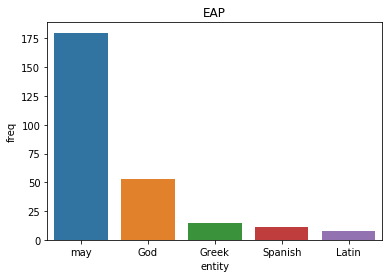

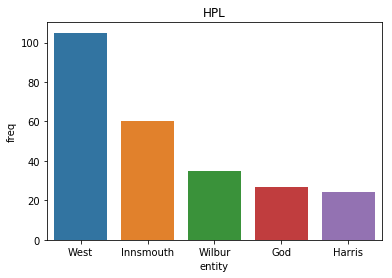

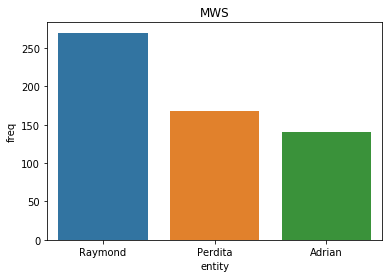

In [76]:
# Frenquent named entities in EAP's writing
sns.barplot(x='entity', y='freq', data=pd.DataFrame(frequent_entities['EAP']).sort_values(by='freq', ascending=False).head())
plt.title('EAP')
plt.show()
# Frenquent named entities in HPL's writing 
sns.barplot(x='entity', y='freq', data=pd.DataFrame(frequent_entities['HPL']).sort_values(by='freq', ascending=False).head())
plt.title('HPL')
plt.show()
# Frenquent named entities in MWS's writing 
sns.barplot(x='entity', y='freq', data=pd.DataFrame(frequent_entities['MWS']).sort_values(by='freq', ascending=False).head())
plt.title('MWS')
plt.show()

### Named Entity Frequencies 